## Librerías y funciones

Lo primero es cargar las librerías y funciones genéricas necesarias.

In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
import seaborn as sns
import string
from string import punctuation
import ast
from collections import Counter

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

import gzip
import pickle


In [ ]:
#!pip install gensim

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K


## 1. Carga de datos

Cargamos los ficheros compirmidos ya con los datos de train/val pre-procesados siguiendo el razonamiento del notebook anterior. En esta ocasión, se han almacenado los datos relativos a los textos preprocesados con su clasificación correspondiente.

In [ ]:
train = pd.read_pickle('./train_emb.pkl.gz')
val = pd.read_pickle('./val_emb.pkl.gz')

In [ ]:
train.shape

(18834, 2)

In [ ]:
train.head()

norm_tweet  class_tweet
0                           put ya hoe ya girlfriend            1
1  hope recruiting woman isi open jihadi finishin...            2
2           daggone twin kick notch time beat yankee            2
3                   big yute slit brow darg lol drop            2
4             austin mahone making bitch horny right            1

In [ ]:
y_train = train[['class_tweet']]
y_val = val[['class_tweet']]

In [ ]:
corpus = train["norm_tweet"]

Existen diferentes técnicas para extraer información de datos de texto sin procesar y usarla para entrenar un modelo de clasificación. En este notebook se implementa el popular modelo Word Embedding (usado con una red neuronal de aprendizaje profundo).

**Word Embedding** es el nombre colectivo de las técnicas de aprendizaje de características en las que las palabras del vocabulario se asignan a vectores de números reales. Estos vectores se calculan a partir de la distribución de probabilidad de cada palabra que aparece antes o después de otra.

En esta ocasión, usaremos el modelo de Word2Vec de Google (aunque se podría considerar otros populares como Glove de Stanford o FastText de Facebook). Word2Vec produce un espacio vectorial, típicamente de varios cientos de dimensiones, con cada palabra única en el corpus, de modo que las palabras que comparten contextos comunes en el corpus se ubican cerca unas de otras en el espacio. 

En nuestro proyecto, vamos a ajustar nuestro propio Word2Vec con el corpus de datos de entrenamiento con gensim. Antes de ajustar el modelo, el corpus debe transformarse en una lista de listas de n-gramas (n=1,2,3)


In [ ]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

Al instalar *Word2Vec*, se debe detallar:

*   El tamaño de destino de los vectores de palabras, nosotros emplearemos 300.
*   La ventana, o la distancia máxima entre la palabra actual y la predicha dentro de una oración, usaremos la longitud media del texto en el corpus.
*   El algoritmo de entrenamiento, utilizaremos skip-grams (sg = 1) ya que en general tiene mejores resultados.


In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
word = "nigger"
nlp[word].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

Dicho todo esto, ¿cómo puede ser útil dicha técnica para predecir el sentimiento del texto? Bueno, las palabras-vectores se pueden usar en una red neuronal como pesos, de la siguiente manera:

1.   Transformar el corpus en secuencias rellenas de identificadores de palabras para obtener una matriz de características.
2.   Crear una matriz de *embeddings* para que el vector de la palabra con id N se ubique en la fila N-ésima .
3. Implementar  una NN con una capa de *embedding* que pondera cada palabra en las secuencias con el vector correspondiente.


Comencemos con la parte de *Feature Engineering* transformando el mismo corpus preprocesado (lista de listas de n-gramas) que se le dio a *Word2Vec* en una lista de secuencias usando tensorflow:

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

La matriz de características X_train tiene una forma de 18834 x 15 (Número de secuencias x longitud máxima de secuencias)

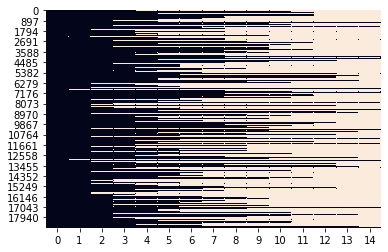

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Cada texto del corpus es ahora una secuencia de identificación con una longitud de 15. Por ejemplo, si un texto tiene 10 tokens, entonces la secuencia se compone de 10 identificaciones + 5 ceros. 

Imprimamos cómo un texto del *train* se ha transformado en una secuencia con el relleno y el vocabulario.

In [ ]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(train["norm_tweet"].iloc[i].split())
print("from: ", train["norm_tweet"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", train["norm_tweet"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[train["norm_tweet"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  put ya hoe ya girlfriend | len: 5
to:  [106  44   3  44 378   0   0   0   0   0   0   0   0   0   0] | len: 15
check:  put  -- idx in vocabulary --> 106
vocabulary:  {'NaN': 1, 'bitch': 2, 'hoe': 3, 'like': 4, 'pussy': 5} ... (padding element, 0)


Antes de continuar, no olvide hacer la misma ingeniería de funciones también en el conjunto de test:


In [ ]:
corpus = val["norm_tweet"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_val = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

Una vez obtenidos nuestros datos de *train* y *test*, ahora vamos a necesitar crear la matriz de *Embedings* que empleará el modelo como matriz de peso en el clasificador.

Antes de proceder a la parte del modelo de clasificación, cabe comentar que los embeddings no se normalizan como input de la NN. (https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them) 

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## 3. Modelo de clasificación

A continuación, vamos a construir un modelo de aprendizaje profundo. 

La NN implementada se estructurará de la siguiente manera:

1. Una capa de *embedding* que toma las secuencias como entrada y los vectores de palabras como pesos. Usaremos la matriz de *embedding* en la primera capa de la red neuronal. Cada id en la secuencia de entrada se utilizará como índice para acceder a la matriz de *embedding*. La salida de esta capa de incrustación será una matriz 2D con un vector de palabra para cada id de palabra en la secuencia de entrada (longitud de la secuencia x tamaño del vector).

2. Una capa de atención simple que no afectará las predicciones, pero que capturará los pesos de cada instancia y nos permitirá construir un buen explicador (no es necesario para las predicciones, solo para la explicabilidad, por lo que puede omitirlo). . El mecanismo de atención se presentó en este documento (https://arxiv.org/abs/1409.0473) como una solución al problema de los modelos de secuencia (es decir, LSTM) para comprender qué partes de un texto extenso son realmente relevantes.

3. Dos capas de LSTM bidireccional para modelar el orden de las palabras en una secuencia en ambas direcciones.
4. Dos capas finales densas que predecirán la probabilidad de cada categoría de los textos. 

Se puede apuntar que dicha arquitectura recuerda ELMo.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
#trainable=False
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=True)(x_in)

## apply attention
x = attention_layer(x, neurons=15)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      4892100     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

Ahora podemos entrenar el modelo y verificar el rendimiento en un subconjunto del conjunto de entrenamiento utilizado para la validación antes de probarlo en el conjunto de prueba real.

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}

In [ ]:
class_weight = {0: 30.,
                1: 1.,
                2: 2.}

training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=1, 
                     validation_split=0.3,class_weight=class_weight)


Epoch 1/10
52/52 [==============================] - 16s 75ms/step - loss: 2.7075 - accuracy: 0.0623 - val_loss: 1.4114 - val_accuracy: 0.0556
Epoch 2/10
52/52 [==============================] - 2s 41ms/step - loss: 2.2000 - accuracy: 0.1541 - val_loss: 0.9851 - val_accuracy: 0.6670
Epoch 3/10
52/52 [==============================] - 2s 40ms/step - loss: 1.3781 - accuracy: 0.7298 - val_loss: 1.0073 - val_accuracy: 0.6022
Epoch 4/10
52/52 [==============================] - 2s 40ms/step - loss: 0.9517 - accuracy: 0.7927 - val_loss: 0.6186 - val_accuracy: 0.7696
Epoch 5/10
52/52 [==============================] - 2s 40ms/step - loss: 0.6948 - accuracy: 0.8415 - val_loss: 0.6238 - val_accuracy: 0.7677
Epoch 6/10
52/52 [==============================] - 2s 38ms/step - loss: 0.5182 - accuracy: 0.8834 - val_loss: 0.5416 - val_accuracy: 0.8147
Epoch 7/10
52/52 [==============================] - 2s 38ms/step - loss: 0.4022 - accuracy: 0.9104 - val_loss: 0.4814 - val_accuracy: 0.8480
Epoch 8/10
5

In [ ]:
y_train.values

array([[1],
       [2],
       [2],
       ...,
       [1],
       [1],
       [0]])

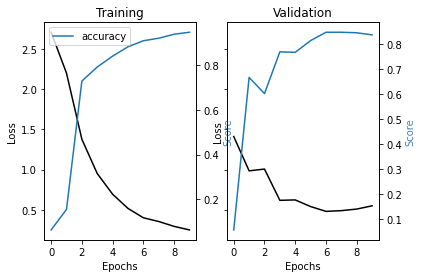

In [ ]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


En 10 épocas, la precisión alcazada es de 0,83. Para completar la evaluación del modelo de *Word Embedding*, predicemos el conjunto de prueba y evaluemos las métricas de *performance* del modelo. Pero, mejor nos fijamos en la matriz de confusión y métricas como F1-score.

In [ ]:
## test
predicted_prob = model.predict(X_val)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, predicted)))
print('\nClassification report:\n{}'.format(classification_report(y_val, predicted)))
print('Accuracy score:{}'.format(accuracy_score(y_val, predicted)))

Confussion matrix:
[[ 123  129   20]
 [ 333 3228   85]
 [  37  190  564]]

Classification report:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32       272
           1       0.91      0.89      0.90      3646
           2       0.84      0.71      0.77       791

    accuracy                           0.83      4709
   macro avg       0.67      0.68      0.66      4709
weighted avg       0.86      0.83      0.84      4709

Accuracy score:0.8313867063070716
